# Prepare the data

In [1]:
# # mount google drive 
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip "/content/drive/MyDrive/dataset.zip"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, random_split
import torchvision
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc

import gc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
Resnet18

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
Resnet18 = torchvision.models.resnet18(pretrained=True)
# modify it to accept 1x150x150 input
Resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

Resnet18.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1))

Resnet18 = Resnet18.to(device)

# Preparing Dataset

In [2]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
    ])

In [3]:
train_dataset = DatasetFolder(
    root='dataset/train/',
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

test_dataset = DatasetFolder(
    root='dataset/val/',
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
    )

In [4]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.9), int(len(train_dataset)*0.1)])

In [5]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Explore the dataset

In [6]:
# Explore the dataset
print('Train dataset size: ', len(train_dataset))
print('Validation dataset size: ', len(val_dataset))
print('Test dataset size: ', len(test_dataset))

# get image shape
print('Image shape: ', train_dataset[0][0].shape)

# get number of classes
print('Number of classes: ', len(train_dataset.dataset.classes))

# type of image tensor
print('Type of image tensor: ', train_dataset[0][0].dtype)

# number of batches in train loader
print('Number of batches in train loader: ', len(train_loader))

Train dataset size:  27000
Validation dataset size:  3000
Test dataset size:  7500
Image shape:  torch.Size([3, 224, 224])
Number of classes:  3
Type of image tensor:  torch.float32
Number of batches in train loader:  422


/home/ossamaak0/miniconda3/envs/pytor/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


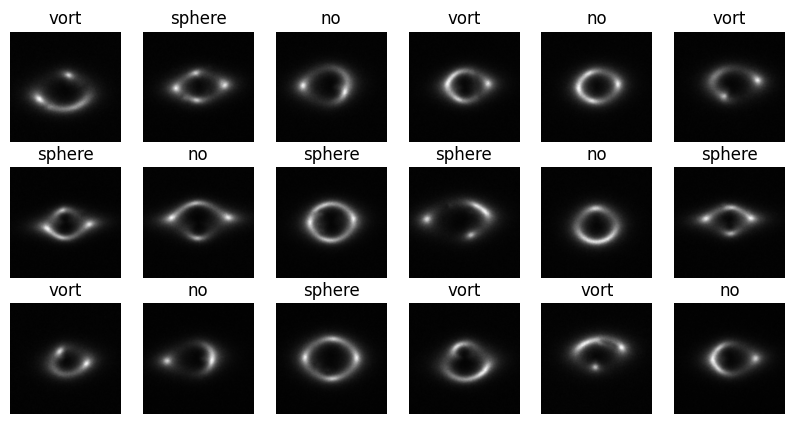

In [7]:
# plot some images
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    rand = torch.randint(0, len(train_dataset), (1,)).item()
    ax.imshow(train_dataset[rand][0].permute(1,2,0), cmap='gray')
    ax.set_title(train_dataset.dataset.classes[train_dataset[rand][1]])
    ax.axis('off')

# Train and Test Functions

In [1]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, n_epochs, scheduler = None):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(1, n_epochs+1):
        # Keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_accuracy = 0.0
        valid_accuracy = 0.0

        
        # Train the model
        model.train()
        for batch, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*inputs.size(0)
            num_correct = (outputs.argmax(1) == labels).type(torch.float).sum().item()
            train_accuracy += num_correct

            # writer.add_scalar("Training loss", loss, global_step = batch)
            # writer.add_scalar("Training Accuracy", num_correct / inputs.shape[0], global_step = batch)
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
          for data in tqdm(valid_loader):
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)

              valid_loss += loss.item()*inputs.size(0)
              num_correct = (outputs.argmax(1) == labels).type(torch.float).sum().item()
              valid_accuracy += num_correct

              # writer.add_scalar("Validation loss", loss, global_step = batch)
              # writer.add_scalar("Validation Accuracy", num_correct / inputs.shape[0], global_step = batch)
        
        # Calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        train_accuracy = train_accuracy/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        valid_accuracy = valid_accuracy/len(valid_loader.dataset)

        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(valid_loss)
        val_accs.append(valid_accuracy)

        scheduler.step(valid_loss)

        
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} | Training Accuracy: {train_accuracy:.6f} | Validation Loss: {valid_loss:.6f} | Validation Accuracy: {valid_accuracy:.6f}')
        if epoch % 2 == 0:
          torch.save(model.state_dict(), f'epoch_{epoch}')
        # writer.add_hparams({"lr": optimizer.param_groups[0]['lr'], "bsize": batch_size}, {"accuracy" : sum(train_accs) / len(train_accs), "loss" : sum(train_losses) / len(train_losses), "val_accuracy" : sum(val_accs) / len(val_accs), "val_loss" : sum(val_losses) / len(val_losses)})
    return train_losses, train_accs, val_losses, val_accs

In [10]:
def evaluate(model, dataloader, loss_fn):
    y_pred = []
    y_true = []
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                total_loss += loss_fn(pred, y).item()
                pred = F.softmax(pred, dim=1)
                y_pred.extend(pred.cpu().detach().numpy())
                y_true.extend(y.cpu().detach().numpy())


    # ROC AUC
    print(f"roc_auc_score: {roc_auc_score(y_true, y_pred, multi_class='ovr'):0.4f}")

    # Loss and Accuracy
    print(f"loss = {total_loss / len(dataloader):0.4f}\naccuracy = {100 * accuracy_score(y_true, np.argmax(y_pred, axis=1)):0.4f}%") 


    # Confusion Matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Reds')
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true, np.array(y_pred)[:,i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=f'Class 0')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=f'Class 1')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=f'Class 2')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

# Model Initialization

## MobileNetV3

In [12]:
MobileNetV3 = torchvision.models.mobilenet_v3_small().to(device)
MobileNetV3.classifier[-1] = nn.Linear(in_features=1024, out_features=3, bias=True)
MobileNetV3.to(device);

# load the model
MobileNetV3.load_state_dict(torch.load('checkpoints/Test1/MobileNetV3_s.pth'))

<All keys matched successfully>

## Resnet18

In [20]:
Resnet18 = torchvision.models.resnet18(weights = True)
Resnet18.fc = nn.Linear(in_features=512, out_features=3, bias=True)
Resnet18.to(device);

# load the model
Resnet18.load_state_dict(torch.load('checkpoints/Resnet18.pth'))


/home/ossamaak0/miniconda3/envs/pytor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Efficient Net

In [22]:
EffNet = torchvision.models.efficientnet_b5(weights=True)
EffNet.classifier[-1] = nn.Sequential(nn.Linear(in_features=2048, out_features=1024, bias=True), nn.Linear(in_features=1024, out_features=3, bias=True))
EffNet.to(device);

# load if trained before
EffNet.load_state_dict(torch.load('checkpoints/EffNetb5.pth'))

<All keys matched successfully>

# Training

In [18]:
gc.collect()
torch.cuda.empty_cache()

In [16]:
# the training function has been used to train different models, all models have been saved
learning_rate = 0.001
batch_size = 32
num_epochs = 20
model = EffNet


optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs, scheduler)

# gc.collect()
# torch.cuda.empty_cache()
print("Finished")

  0%|          | 0/118 [00:00<?, ?it/s]/home/ossamaak0/miniconda3/envs/pytor/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 118/118 [01:27<00:00,  1.34it/s]


roc_auc_score: 0.9741
loss = 0.3270
accuracy = 88.6667%


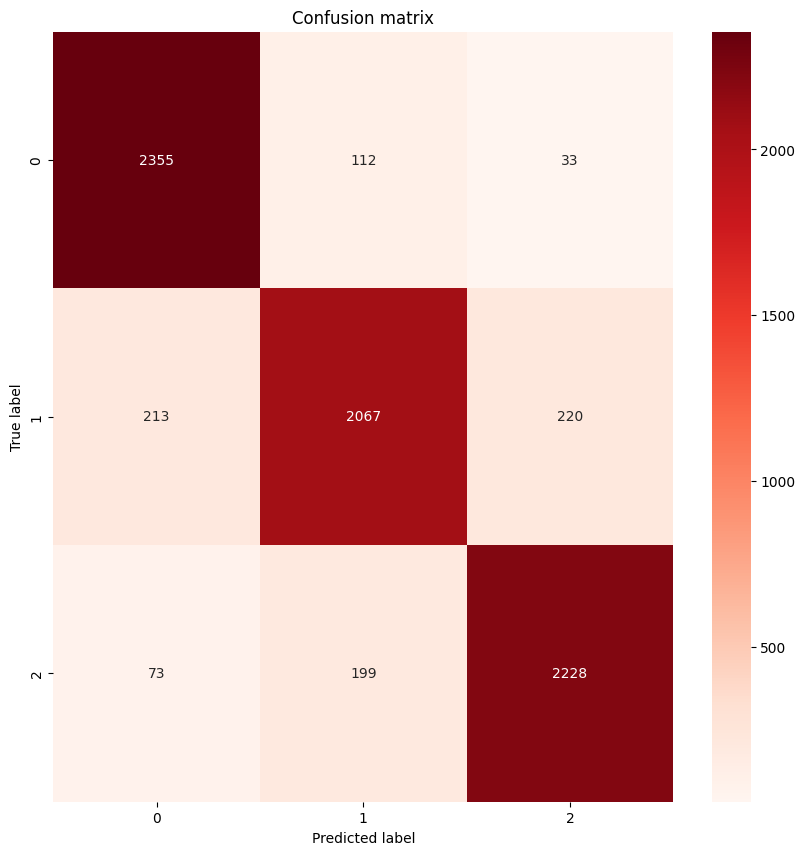

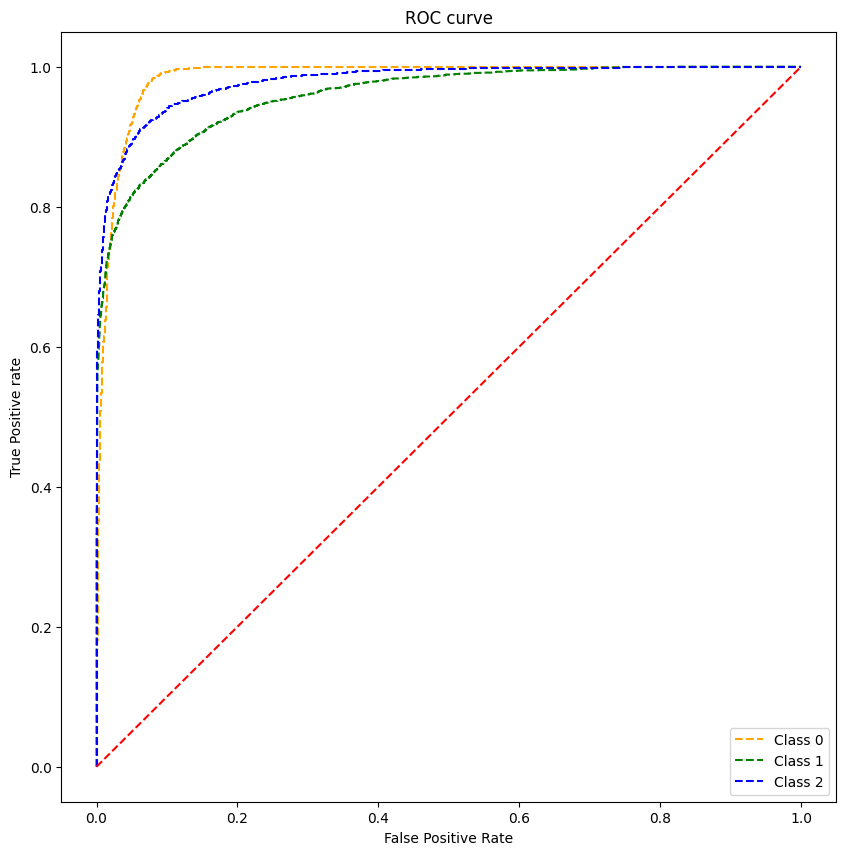

In [13]:
evaluate(MobileNetV3, test_loader, nn.CrossEntropyLoss())